# Project 2: Ames Housing Data and Kaggle Challenge 

General Assembly DSI 19 Project 2 Adrian Teng 

# Executive Summary

In this project, it is splitted into three parts respectively:

- Data Cleaning (01_data_cleaning)
- Exploratory Data Analysis (02_eda)
- Conclusion (03_conclusion)

In the third notebook, 03_conclusion, base line model was created with the top two features using linear regression to do comparison. Subsequently, dummies was added and tested with linear regression again. Next, standard scalar was used to test for Ridge and Lasso.

# Content

- Base Line Model
- Getting Dummies
- Linear Regression
- Standard Scaler
- Ridge
- Lasso
- Conclusion
- Recommendation

In [222]:
#import libraries

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#import cleaned datas
clean_ames_train = pd.read_csv('../datasets/clean_train.csv')
clean_ames_test = pd.read_csv('../datasets/clean_test.csv')

# show all data columns and rows
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

#removing the 'Unnamed: 0'
clean_ames_train = clean_ames_train.drop(columns = ["Unnamed: 0"], axis = 1)
clean_ames_test = clean_ames_test.drop(columns = ["Unnamed: 0"], axis = 1)

#get numerical columns into a list
numerical_colns = clean_ames_train._get_numeric_data()
numerical_colns = list(numerical_colns)

#get non numerical columns into a list
categorical_colns = [i for i in clean_ames_train.columns if i not in numerical_colns]
categorical_colns = list(categorical_colns)

#new feature total area
def add_total_area(w):
    #adding all the area from basement to second floor to a single feature
    w['total_area'] = w['total_bsmt_sf'] + w['1st_flr_sf'] + w['2nd_flr_sf']

add_total_area(clean_ames_train)
add_total_area(clean_ames_test)
numerical_colns.append('total_area')

#removing interaction points
numberical_colns = [x for x in numerical_colns if x not in ['total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf']]

## Base Line Model

### Calculate the base line model with the top two features correlated to 'saleprice'

In [223]:
#create feature matrix (X) and target vector(y)
X0 = clean_ames_train[['gr_liv_area', 'overall_qual']]
y = clean_ames_train['saleprice']

#train and test split
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y, random_state=42)

#instantiate and fit model
lr0 = LinearRegression()
lr0.fit(X0_train, y0_train)

#calculate predictions 
pred0 = lr0.predict(X0_test)

#print regression metrics
print('cross val r2', cross_val_score(lr0, X0_train, y0_train, cv=5).mean())
print('train score r2', lr0.score(X0_train, y0_train))
print('test r2', lr0.score(X0_test, y0_test))
print('coef',lr0.coef_)

cross val r2 0.7421838494662962
train score r2 0.7477165023413908
test r2 0.7530433334607131
coef [   63.74405567 32104.71386231]


- The R2 scores are relatively close to one another, and 0.75 is in the moderate range. 
- Coefficents tell us that the price increase 64 and 32104 dollar respecitively per unit, for garage_liv_area and overall_quall respectively


## Getting dummies

In [224]:
#get dummies for train data
dummies_ames_train = pd.get_dummies(clean_ames_train, columns = categorical_colns, drop_first=True)

In [225]:
dummies_ames_train.shape

(2049, 243)

In [226]:
#setting the dummies model
dummies_model = [x for x in dummies_ames_train.columns if x != ('saleprice')]

In [227]:
#get dummies for test data
dummies_ames_test = pd.get_dummies(clean_ames_test, columns= categorical_colns, drop_first=True)

In [228]:
dummies_ames_test.shape

(879, 230)

In [229]:
#finding missing columns 
missing_colns = set(dummies_ames_train.columns) - set(dummies_ames_test.columns)
#set missing columns in test with default value equal to 0
for c in missing_colns:
     dummies_ames_test[c] = 0
#Ensure the order of columns in test is same as in train
dummies_ames_test = dummies_ames_test[dummies_model]

In [230]:
dummies_ames_test.shape

(879, 242)

## Linear Regression

In [231]:
X1 = dummies_ames_train[dummies_model]
y1 = dummies_ames_train['saleprice']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42, test_size = 0.05)

In [232]:
# cross-validation of train test split

lr1 = LinearRegression()
print(cross_val_score(lr1, X1_train, y1_train, cv=3))
print(cross_val_score(lr1, X1_train, y1_train, cv=3).mean())

[0.91483127 0.90296615 0.89281736]
0.9035382563087774


## Standard Scaler

In [233]:
# Standardize X1_train and X1_test using Standard Scaler

# Instantiate Standard Scaler
ss = StandardScaler()

# Fit Standard Scaler to X1_train and transform X1_train
X1_train_sc = ss.fit_transform(X1_train)

# Transform X1_test using Standard Scaler
X1_test_sc = ss.transform(X1_test)

# Standardize ames_test using Standard Scaler
ss = StandardScaler()
dummies_ames_test_sc = ss.fit_transform(dummies_ames_test)

## Ridge

In [234]:
# create linear model using Ridge
ridge_model = RidgeCV()
ridge_model = ridge_model.fit(X1_train_sc, y1_train)

In [235]:
# check score of X1_train vs X1_test for overfit
print(ridge_model.score(X1_train_sc, y1_train))
print(ridge_model.score(X1_test_sc, y1_test))

0.9414118755357928
0.946854781183282


In [236]:
ridge_features = pd.DataFrame(X1_train.columns, columns=['feature'])
ridge_features['coef'] = ridge_model.coef_
ridge_features['abs_coef'] = np.abs(ridge_model.coef_)
ridge_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
154,exter_qual_TA,-12096.690762,12096.690762
16,gr_liv_area,11085.493229,11085.493229
204,kitchen_qual_Gd,-10880.975090,10880.975090
205,kitchen_qual_TA,-10871.410250,10871.410250
153,exter_qual_Gd,-10382.839417,10382.839417
37,total_area,10115.884661,10115.884661
226,garage_qual_TA,-9679.666967,9679.666967
6,year_built,9486.303442,9486.303442
4,overall_qual,9111.082806,9111.082806
14,2nd_flr_sf,8040.808496,8040.808496


In [237]:
# prediction function for ridge

y1_pred = ridge_model.predict(dummies_ames_test_sc)
y1_pred.mean()



181768.8422404932

In [238]:
submission_test1 = pd.DataFrame(y1_pred, columns=['saleprice'])
submission_test1['id'] = clean_ames_test['id']
submission_test1 = submission_test1[['id', 'saleprice']]

In [239]:
submission_test1.head(10)

,id,saleprice
0,2658,156892.485808
1,2718,152810.791353
2,2414,208742.574257
3,1989,140124.154437
4,625,172564.785307
5,333,88225.343612
6,1327,113749.742517
7,858,151316.228934
8,95,179784.511566
9,1568,169285.176762


## Lasso

In [240]:
# create linear model using Lasso
linear = LassoCV()
model = linear.fit(X1_train_sc, y1_train)

In [241]:
# check score of X1_train vs X1_test for overfit
print(model.score(X1_train_sc, y1_train))
print(model.score(X1_test_sc, y1_test))

0.9387200909885182
0.9436026739366639


In [242]:
lasso_features = pd.DataFrame(X1_train.columns, columns=['feature'])
lasso_features['coef'] = model.coef_
lasso_features['abs_coef'] = np.abs(model.coef_)
lasso_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
37,total_area,15917.890652,15917.890652
16,gr_liv_area,15390.900410,15390.900410
204,kitchen_qual_Gd,-10428.814154,10428.814154
205,kitchen_qual_TA,-10420.868352,10420.868352
154,exter_qual_TA,-10329.039164,10329.039164
4,overall_qual,10306.636355,10306.636355
6,year_built,9148.969138,9148.969138
153,exter_qual_Gd,-8608.031675,8608.031675
9,bsmtfin_sf_1,7748.586445,7748.586445
165,bsmt_qual_Gd,-7071.693239,7071.693239


In [243]:
# prediction function for Lasso

y2_pred = model.predict(dummies_ames_test_sc)
y2_pred.mean()

181768.84224049328

In [244]:
y_pred.shape

(879,)

In [245]:
submission = pd.DataFrame(y2_pred, columns=['saleprice'])
submission['id'] = clean_ames_test['id']
submission = submission[['id', 'saleprice']]

In [246]:
submission.head(20)

,id,saleprice
0,2658,151472.593022
1,2718,154991.333444
2,2414,210629.080582
3,1989,115682.958178
4,625,175542.479203
5,333,87846.044512
6,1327,111037.332559
7,858,151194.124446
8,95,180407.322671
9,1568,169706.057065


<AxesSubplot:>

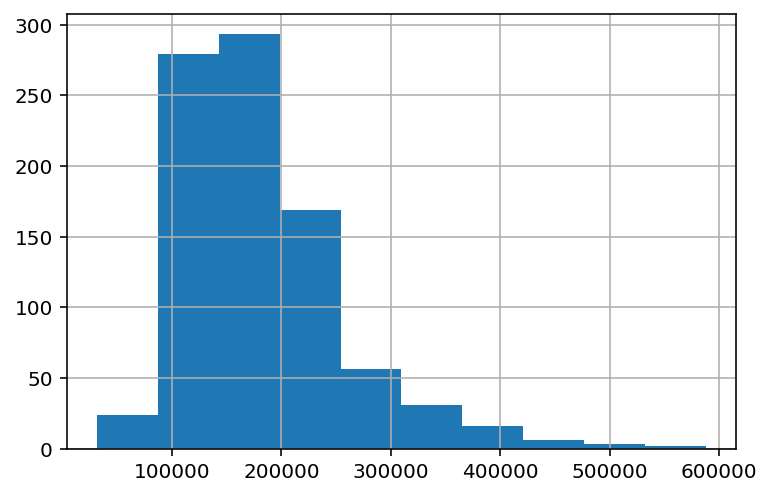

In [247]:
submission['saleprice'].hist()

The distribution is skwed right, similar to given 'saleprice'

In [248]:
# write predictions to csv
submission.to_csv('submission_01', index=False)

Kaggle Test Score: 32595.69444 (Lasso)

## Conclusion

For the base line model, I have used linear regression for comparsion. Starting without getting dummies with only top two features, the score was relatively decent ~0.75. However, after getting dummies into the data and by adding more features into linear regression again, the score improved significantly ~0.91. 

Next, before trying Lasso and Ridge I have decided to use standard scalar. The Ridge score and Lasso score increased slightly and is comparable ~0.93/0.94. They result between Lasso and Ridge is similar and very close to perfect score 1.

Thus, I have decided to let Kaggle do the job and see which model will get a better score. In the end Lasso had a better score at 32595.7 and it will be recommended to predict the price of a house at sale.

Looking into the top 3 features against sale price:
- overall quality
- total area
- garage area

Overall quality
- Most of the house sold is at 5-7(average to good), at the price range between 50k-400k
- 8-9(above good), have the highest spread of price and the lowest minimum

Total Area
- Very high correlation, close to higher area almost equal to higher price
- High concentration 1800 to 3600 sq feet, around 100k to 360k

Garage Size
- High concentration 200-600 sq feet (good fit for 1-2 cars), around 80k-260k

In [249]:
# number of house sold at different qualities## Recommendation
clean_ames_train['overall_qual'].value_counts()

5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     21
2       9
1       4
Name: overall_qual, dtype: int64

Text(0, 0.5, 'Saleprice')

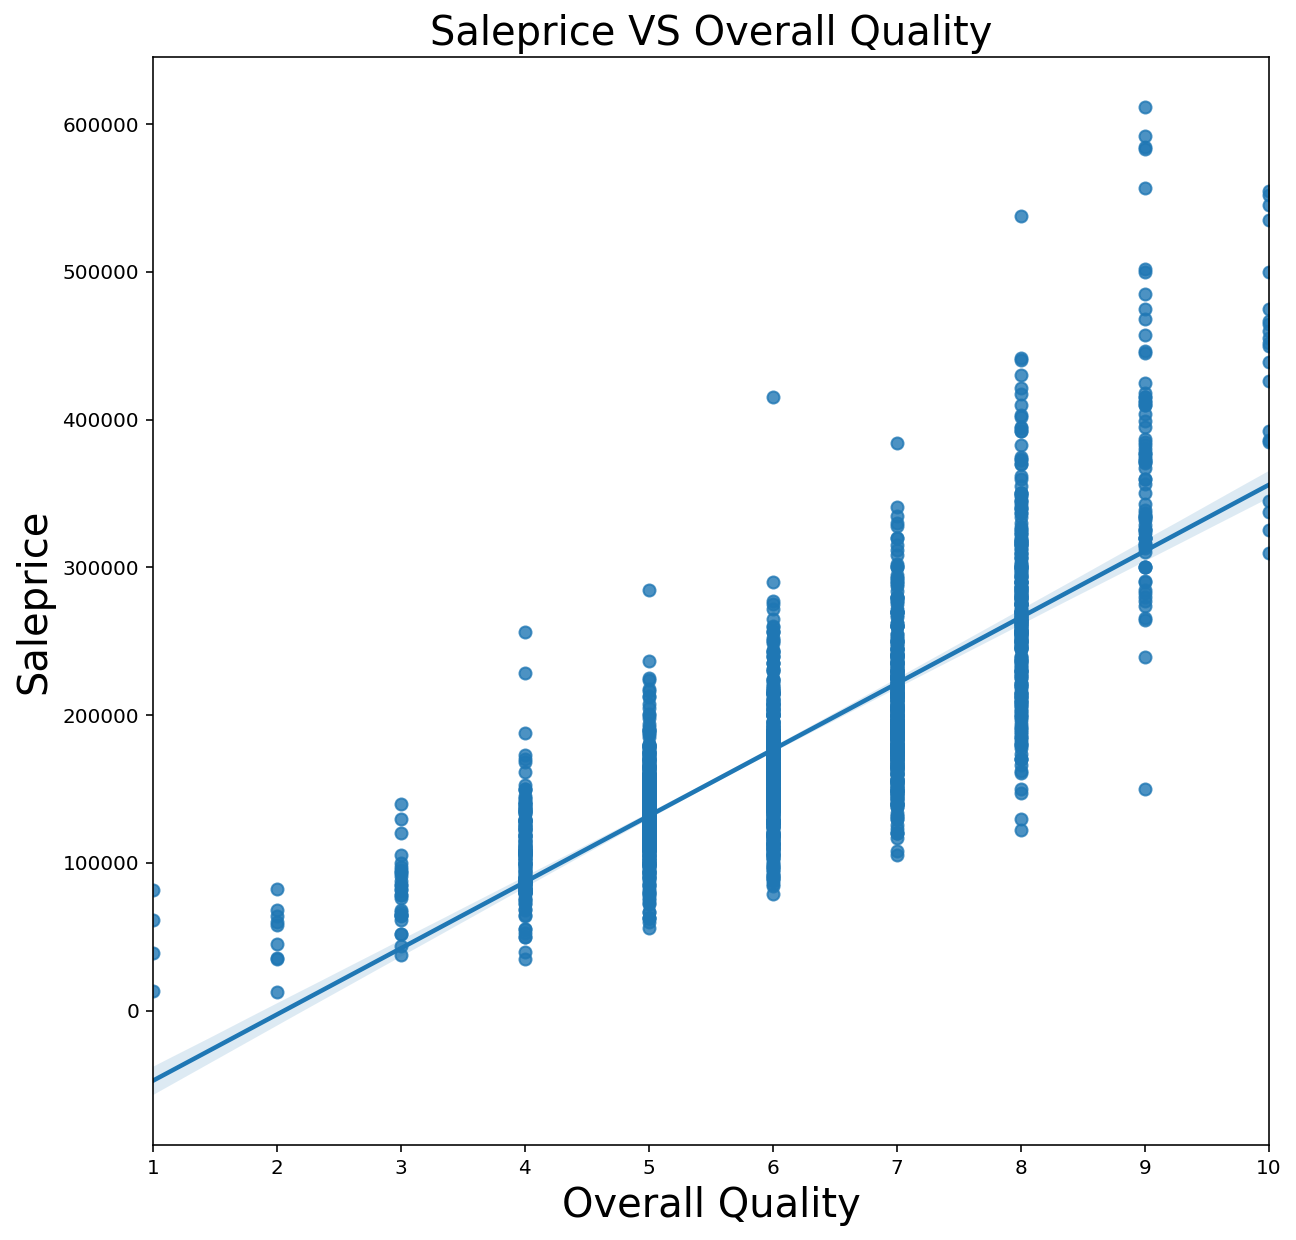

In [250]:
#plotting saleprice vs overquality
ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(y='saleprice', x='overall_qual', data=clean_ames_train[['saleprice','overall_qual']])
ax.set_title('Saleprice VS Overall Quality',fontsize=20)
ax.set_xlabel('Overall Quality',fontsize=20)
ax.set_ylabel('Saleprice',fontsize=20)

Text(0, 0.5, 'Saleprice')

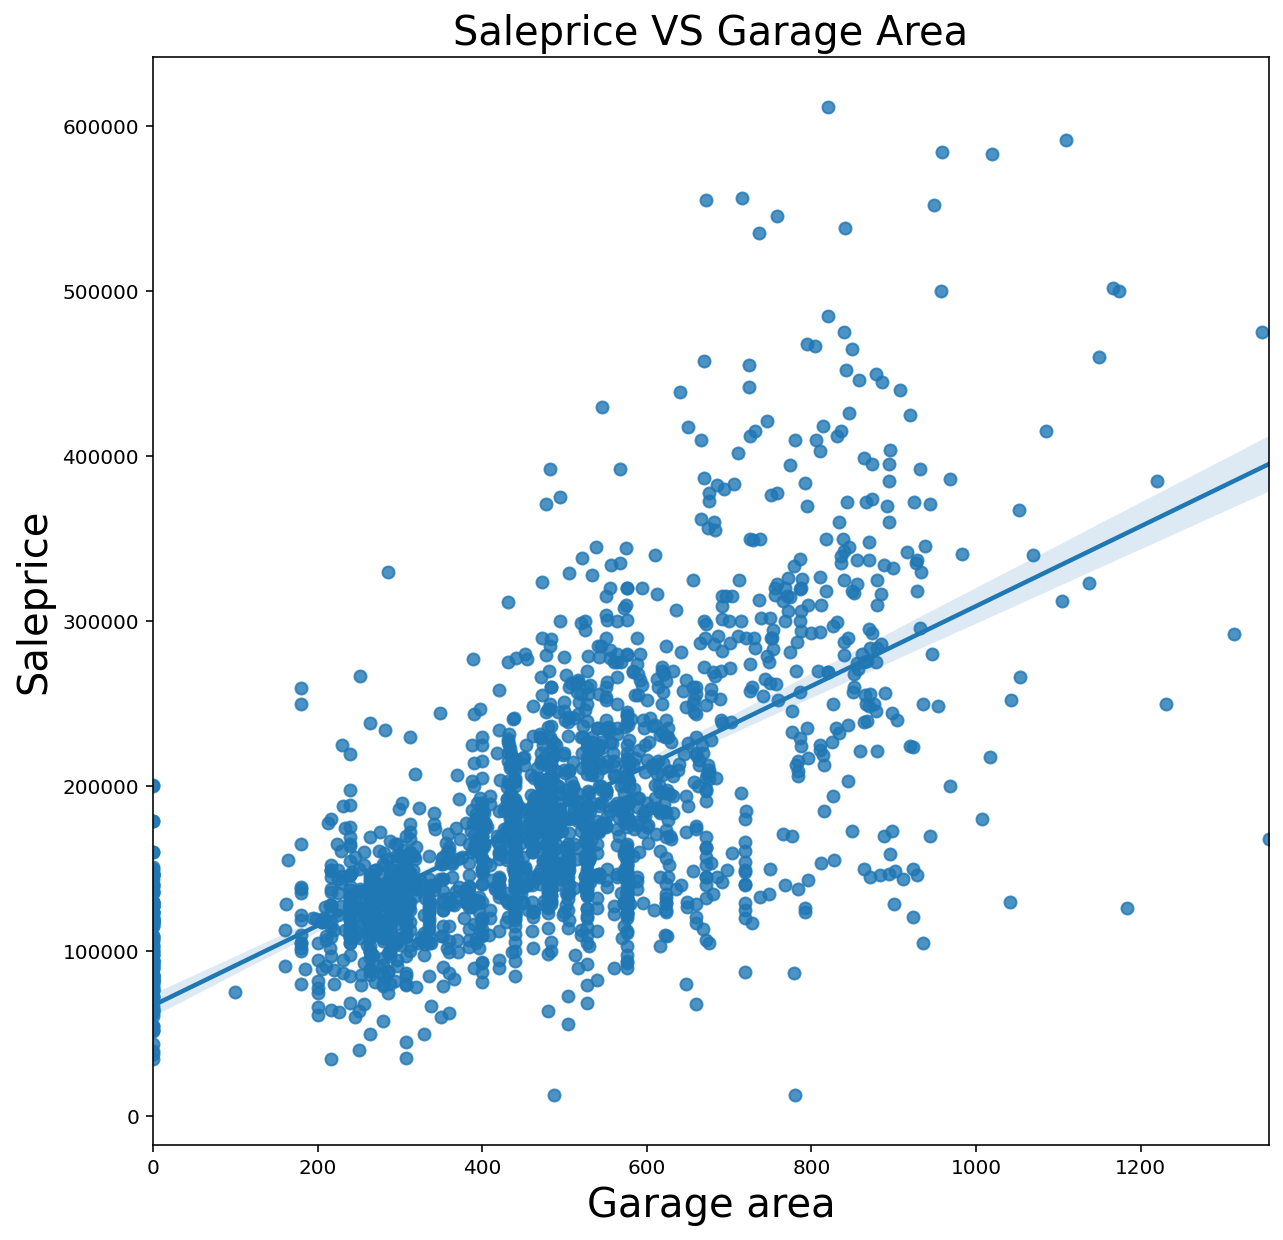

In [251]:
#plotting saleprice vs garage_area
ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(y='saleprice', x='garage_area', data=clean_ames_train[['saleprice','garage_area']])
ax.set_title('Saleprice VS Garage Area',fontsize=20)
ax.set_xlabel('Garage area',fontsize=20)
ax.set_ylabel('Saleprice',fontsize=20)

Text(0, 0.5, 'Saleprice')

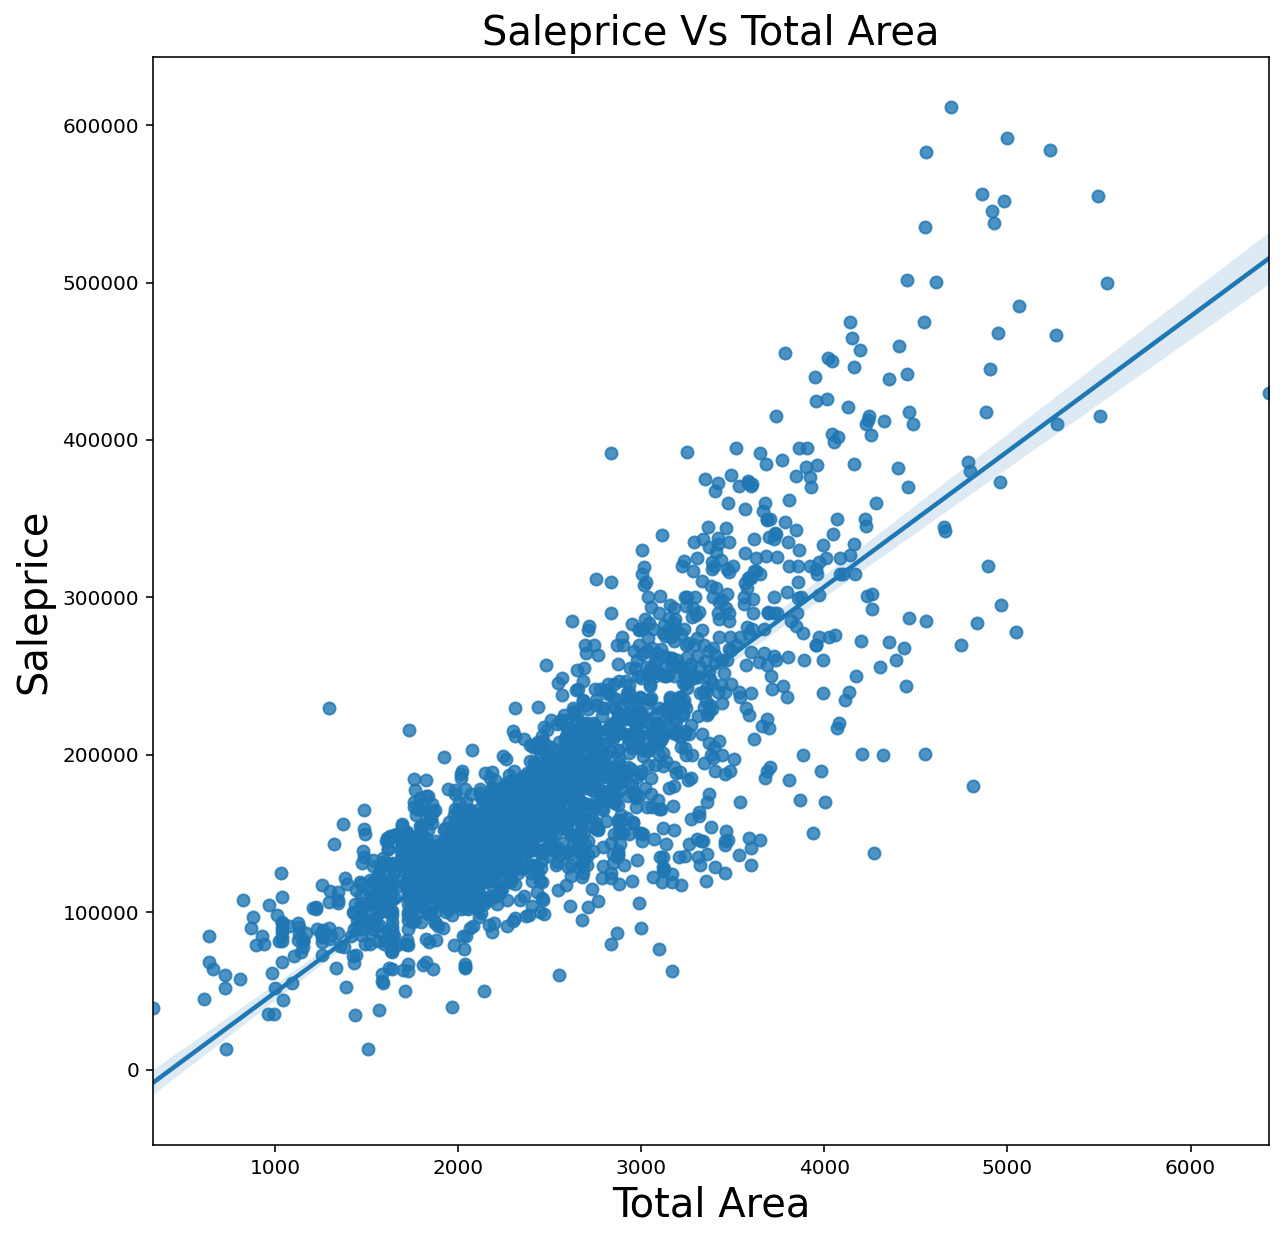

In [252]:
#plotting saleprice vs total area
ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(y='saleprice', x='total_area', data=clean_ames_train[['saleprice','total_area']])
ax.set_title('Saleprice Vs Total Area',fontsize=20)
ax.set_xlabel('Total Area',fontsize=20)
ax.set_ylabel('Saleprice',fontsize=20)

## Recommendation



- Model to use Lasso
- Keeping the quality average to good conditions, at least clean and nothing is spoil
- 200-600 sq feet for garage size, good fit 1-2 cars (excess space can make for other purpose)
- Separate big area to 2 units or adding essential facilities ( within 1800 to 3600 sq feet)